In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import holidays

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [3]:
# train_df = pd.read_parquet(Path("data") / "train.parquet")
# weather_data = pd.read_csv(Path("data") / "external_data.csv")

# weather_data['date'] = pd.to_datetime(weather_data['date'])
# train_df['date'] = pd.to_datetime(train_df[['year', 'month', 'day']])

# merged_data = pd.merge(train_df, weather_data, on='date', how='left')

# threshold = 0.7 * len(merged_data)
# merged_data = merged_data.loc[:, merged_data.isnull().sum() <= threshold]
# merged_data = merged_data.fillna(merged_data.median(numeric_only=True))

# merged_data.to_parquet("data/merged_data.parquet", index=False)

# Feature Engineering

In [4]:
def _encode_dates(X):
    X = X.copy()
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Apply cyclical encoding
    X["hour_sin"] = np.sin(2 * np.pi * X["hour"] / 24)
    X["hour_cos"] = np.cos(2 * np.pi * X["hour"] / 24)
    X["month_sin"] = np.sin(2 * np.pi * X["month"] / 12)
    X["month_cos"] = np.cos(2 * np.pi * X["month"] / 12)
    X["weekday_sin"] = np.sin(2 * np.pi * X["weekday"] / 7)
    X["weekday_cos"] = np.cos(2 * np.pi * X["weekday"] / 7)

    return X

In [5]:
data = _encode_dates(data)

In [6]:
data

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,...,month,day,weekday,hour,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,9,1,1,2,0.500000,8.660254e-01,-1.0,-1.836970e-16,0.781831,0.623490
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,9,1,1,3,0.707107,7.071068e-01,-1.0,-1.836970e-16,0.781831,0.623490
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,9,1,1,4,0.866025,5.000000e-01,-1.0,-1.836970e-16,0.781831,0.623490
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,9,1,1,15,-0.707107,-7.071068e-01,-1.0,-1.836970e-16,0.781831,0.623490
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,9,1,1,18,-1.000000,-1.836970e-16,-1.0,-1.836970e-16,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929175,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,445.0,2021-09-09 06:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,...,9,9,3,6,1.000000,6.123234e-17,-1.0,-1.836970e-16,0.433884,-0.900969
929178,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,145.0,2021-09-09 10:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,...,9,9,3,10,0.500000,-8.660254e-01,-1.0,-1.836970e-16,0.433884,-0.900969
929181,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,218.0,2021-09-09 15:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,...,9,9,3,15,-0.707107,-7.071068e-01,-1.0,-1.836970e-16,0.433884,-0.900969
929184,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,21.0,2021-09-09 22:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,...,9,9,3,22,-0.500000,8.660254e-01,-1.0,-1.836970e-16,0.433884,-0.900969


In [7]:
def _encode_categorical_features(X):
    X = X.copy()
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    encoded_features = encoder.fit_transform(X[["counter_name", "site_name"]])
    encoded_df = pd.DataFrame(
        encoded_features,
        columns=encoder.get_feature_names_out(["counter_name", "site_name"]),
        index=X.index
    )
    # Drop original columns and add encoded features
    X = X.drop(columns=["counter_name", "site_name"], errors="ignore")
    X = pd.concat([X, encoded_df], axis=1)
    
    return X

In [8]:
def _add_rush_hour_indicator(X):
    X = X.copy()
    X["is_rush_hour"] = X["hour"].isin([7, 8, 9, 17, 18, 19]).astype(int)
    return X

In [9]:
def _add_weekend_indicator(X):
    X = X.copy()
    X["is_weekend"] = (X["weekday"] >= 5).astype(int)
    return X

In [10]:
def _add_holiday_indicator(X):
    X = X.copy()
    france_holidays = holidays.FR()  # Use the holidays package for France
    X["is_holiday"] = X["date"].dt.date.apply(lambda x: 1 if x in france_holidays else 0)
    return X

In [11]:
# Define feature dropping for low predictive value and date
def _drop_low_value_features(X):
    X = X.copy()
    X.drop(columns=['date', 'year', 'month', 'day', 'site_id', 'counter_id', 'date', 'counter_installation_date', 
                    'counter_technical_id', 'coordinates', 'latitude', 'longitude'], inplace=True)
    return X

In [12]:
preprocessor = Pipeline(steps=[
    ("add_rush_hour", FunctionTransformer(_add_rush_hour_indicator, validate=False)),
    ("add_weekend", FunctionTransformer(_add_weekend_indicator, validate=False)),
    ("add_holiday", FunctionTransformer(_add_holiday_indicator, validate=False)),
    ("encode_categorical", FunctionTransformer(_encode_categorical_features, validate=False)),
    ("encode_dates", FunctionTransformer(_encode_dates, validate=False)),
    ("drop_low_value_features", FunctionTransformer(_drop_low_value_features, validate=False)),
])

In [13]:
data = preprocessor.fit_transform(data)

In [14]:
data

,bike_count,log_bike_count,weekday,hour,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,...,site_name_Pont de Bercy,site_name_Pont de la Concorde S-N,site_name_Pont des Invalides N-S,site_name_Pont des Invalides S-N,site_name_Quai d'Orsay,site_name_Totem 64 Rue de Rivoli,site_name_Totem 73 boulevard de Sébastopol,site_name_Totem 85 quai d'Austerlitz,site_name_Totem Cours la Reine,site_name_Voie Georges Pompidou
48321,0.0,0.000000,1,2,0.500000,8.660254e-01,-1.0,-1.836970e-16,0.781831,0.623490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48324,1.0,0.693147,1,3,0.707107,7.071068e-01,-1.0,-1.836970e-16,0.781831,0.623490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48327,0.0,0.000000,1,4,0.866025,5.000000e-01,-1.0,-1.836970e-16,0.781831,0.623490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48330,4.0,1.609438,1,15,-0.707107,-7.071068e-01,-1.0,-1.836970e-16,0.781831,0.623490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48333,9.0,2.302585,1,18,-1.000000,-1.836970e-16,-1.0,-1.836970e-16,0.781831,0.623490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929175,445.0,6.100319,3,6,1.000000,6.123234e-17,-1.0,-1.836970e-16,0.433884,-0.900969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
929178,145.0,4.983607,3,10,0.500000,-8.660254e-01,-1.0,-1.836970e-16,0.433884,-0.900969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
929181,218.0,5.389072,3,15,-0.707107,-7.071068e-01,-1.0,-1.836970e-16,0.433884,-0.900969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
929184,21.0,3.091042,3,22,-0.500000,8.660254e-01,-1.0,-1.836970e-16,0.433884,-0.900969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## MODELS

In [15]:
data.columns

Index(['bike_count', 'log_bike_count', 'weekday', 'hour', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos',
       'is_rush_hour', 'is_weekend', 'is_holiday',
       'counter_name_152 boulevard du Montparnasse E-O',
       'counter_name_152 boulevard du Montparnasse O-E',
       'counter_name_18 quai de l'Hôtel de Ville NO-SE',
       'counter_name_18 quai de l'Hôtel de Ville SE-NO',
       'counter_name_20 Avenue de Clichy NO-SE',
       'counter_name_20 Avenue de Clichy SE-NO',
       'counter_name_254 rue de Vaugirard NE-SO',
       'counter_name_254 rue de Vaugirard SO-NE',
       'counter_name_27 quai de la Tournelle NO-SE',
       'counter_name_27 quai de la Tournelle SE-NO',
       'counter_name_28 boulevard Diderot E-O',
       'counter_name_28 boulevard Diderot O-E',
       'counter_name_36 quai de Grenelle NE-SO',
       'counter_name_36 quai de Grenelle SO-NE',
       'counter_name_38 rue Turbigo NE-SO',
       'counter_name_38 rue Turbig

In [16]:
X = data.drop(columns=['bike_count', 'log_bike_count']).select_dtypes(include=['number'])
y = data['log_bike_count']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"Train set: {X_train.shape}, Validation set: {X_valid.shape}")

Train set: (397461, 97), Validation set: (99366, 97)


In [17]:
print("Columns in X_train:", X_train.columns)
print("Columns in X_valid:", X_valid.columns)

Columns in X_train: Index(['weekday', 'hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'weekday_sin', 'weekday_cos', 'is_rush_hour', 'is_weekend',
       'is_holiday', 'counter_name_152 boulevard du Montparnasse E-O',
       'counter_name_152 boulevard du Montparnasse O-E',
       'counter_name_18 quai de l'Hôtel de Ville NO-SE',
       'counter_name_18 quai de l'Hôtel de Ville SE-NO',
       'counter_name_20 Avenue de Clichy NO-SE',
       'counter_name_20 Avenue de Clichy SE-NO',
       'counter_name_254 rue de Vaugirard NE-SO',
       'counter_name_254 rue de Vaugirard SO-NE',
       'counter_name_27 quai de la Tournelle NO-SE',
       'counter_name_27 quai de la Tournelle SE-NO',
       'counter_name_28 boulevard Diderot E-O',
       'counter_name_28 boulevard Diderot O-E',
       'counter_name_36 quai de Grenelle NE-SO',
       'counter_name_36 quai de Grenelle SO-NE',
       'counter_name_38 rue Turbigo NE-SO',
       'counter_name_38 rue Turbigo SO-NE',
       'c

In [18]:
print(X_train.info())
print(X_train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 397461 entries, 48321 to 779232
Data columns (total 97 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   weekday                                                       397461 non-null  int32  
 1   hour                                                          397461 non-null  int32  
 2   hour_sin                                                      397461 non-null  float64
 3   hour_cos                                                      397461 non-null  float64
 4   month_sin                                                     397461 non-null  float64
 5   month_cos                                                     397461 non-null  float64
 6   weekday_sin                                                   397461 non-null  float64
 7   weekday_cos                                              

In [19]:
print(mean_squared_error)

<function mean_squared_error at 0x1445049d0>


#### Basic Linear Model

In [20]:
linear_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("linear_model", LinearRegression())
])

linear_pipeline.fit(X_train, y_train)

y_train_pred = linear_pipeline.predict(X_train)
y_valid_pred = linear_pipeline.predict(X_valid)

train_rmse = root_mean_squared_error(y_train, y_train_pred)
valid_rmse = root_mean_squared_error(y_valid, y_valid_pred)

print(f"Linear Regression - Train RMSE: {train_rmse:.2f}")
print(f"Linear Regression - Validation RMSE: {valid_rmse:.2f}")

Linear Regression - Train RMSE: 0.84
Linear Regression - Validation RMSE: 1.34


#### Ridge Regression

In [21]:
# Train and evaluate a Ridge regression model
ridge_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("ridge_model", Ridge(alpha=1.0))
])

ridge_pipeline.fit(X_train, y_train)

# Predictions
y_train_pred = ridge_pipeline.predict(X_train)
y_valid_pred = ridge_pipeline.predict(X_valid)

# RMSE
ridge_train_rmse = root_mean_squared_error(y_train, y_train_pred)
ridge_valid_rmse = root_mean_squared_error(y_valid, y_valid_pred)

print(f"Ridge Regression - Train RMSE: {ridge_train_rmse:.2f}")
print(f"Ridge Regression - Validation RMSE: {ridge_valid_rmse:.2f}")

Ridge Regression - Train RMSE: 0.84
Ridge Regression - Validation RMSE: 1.34


### Random Forest

In [22]:
# # Train and evaluate a Random Forest Regressor
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# # Predictions
# y_train_pred = rf_model.predict(X_train)
# y_valid_pred = rf_model.predict(X_valid)

# # RMSE
# rf_train_rmse = root_mean_squared_error(y_train, y_train_pred)
# rf_valid_rmse = root_mean_squared_error(y_valid, y_valid_pred)

# print(f"Random Forest - Train RMSE: {rf_train_rmse:.2f}")
# print(f"Random Forest - Validation RMSE: {rf_valid_rmse:.2f}")

long load times, so disables for now, last RMSE was 1.22, so we moved forward to XGBoost

In [23]:
# features = ["pmer", "t", "u", "rr1", "rr3", "rr6", "rr12", "rr24", "dd", "ff",
#             "hour_sin", "hour_cos", "weekday", "is_weekend"]
# X = data[features]
# y = data["log_bike_count"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse}")
# print(f"R^2 Score: {r2}")

#### XGBOOST

In [24]:
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

class XGBRegressorCompat(XGBRegressor, BaseEstimator, RegressorMixin):
    def __sklearn_tags__(self):
        return {"non_deterministic": True}

# Define features and target variable
features = [
    col for col in data.columns
    if col not in ["log_bike_count", "bike_count", "counter_id", "coordinates"]
]
X = data[features]
y = data["log_bike_count"]

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the XGBoost Regressor
xgb_model = XGBRegressorCompat(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage
    max_depth=5,             # Maximum depth of a tree
    random_state=42,         # For reproducibility
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8     # Subsample ratio of columns when constructing each tree
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_valid_pred = xgb_model.predict(X_valid)

# Calculate RMSE
train_rmse = root_mean_squared_error(y_train, y_train_pred)
valid_rmse = root_mean_squared_error(y_valid, y_valid_pred)

print(f"XGBoost - Train RMSE: {train_rmse:.2f}")
print(f"XGBoost - Validation RMSE: {valid_rmse:.2f}")

XGBoost - Train RMSE: 0.60
XGBoost - Validation RMSE: 0.60


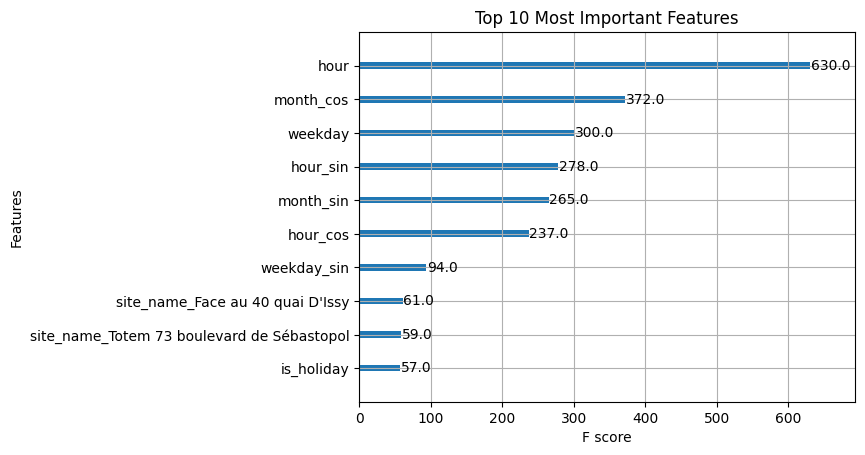

In [25]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Most Important Features")
plt.show()

In [26]:
print(xgb_model.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


#### Neural Network

In [27]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Define features and target variable
# features = [
#     col for col in data.columns
#     if col not in ["log_bike_count", "bike_count", "counter_id", "coordinates"]
# ]
# X = data[features].values
# y = data["log_bike_count"].values

# # Split the data into training and validation sets
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# # Normalize the features
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_valid = scaler.transform(X_valid)

# # Define the neural network
# def create_model(input_dim):
#     model = Sequential([
#         Dense(128, activation='relu', input_dim=input_dim),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(64, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.2),
#         Dense(1)  # Output layer for regression
#     ])
#     return model

# # Compile the model
# model = create_model(input_dim=X_train.shape[1])
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

# # Train the model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_valid, y_valid),
#     epochs=50,
#     batch_size=32,
#     verbose=1
# )

# # Evaluate the model
# y_train_pred = model.predict(X_train).flatten()
# y_valid_pred = model.predict(X_valid).flatten()

# # Calculate RMSE
# train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
# valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

# print(f"Neural Network - Train RMSE: {train_rmse:.2f}")
# print(f"Neural Network - Validation RMSE: {valid_rmse:.2f}")

# # Plot training and validation loss
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss')
# plt.show()

### Hyperparameter tuning

In [28]:
# to be completed

# Test data

In [29]:
test_data = pd.read_parquet(Path("data") / "final_test.parquet")

In [30]:
test_data.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429


In [31]:
test_data = _encode_dates(test_data)

In [32]:
# Preprocess the test data
test_data = preprocessor.transform(test_data)

In [33]:
test_predictions = xgb_model.predict(test_data)

In [37]:
submission_df = pd.DataFrame({
    "Id": range(len(test_predictions)),  # Assuming sequential indices for Id
    "log_bike_count": test_predictions
})


In [38]:
# Save to CSV
submission_file_path = "submission.csv"
submission_df.to_csv(submission_file_path, index=False)

print(f"Submission file saved to {submission_file_path}")

Submission file saved to submission.csv
